In [ ]:
%matplotlib

In [ ]:
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',    100)      # DataFrame 데이터 확인 시 최대 표시 행 수
pd.set_option('display.max_columns', 100)      # DataFrame 데이터 확인 시 최대 표시 열 수

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(777) # 모든 학생들의 학습 효과가 같게 하기 위해 랜덤으로 부여되는 값을 하나로 통일하자는 뜻

## 데이터 불러오기

In [4]:
Fold = 5

# k-fold 학습/검증 데이터
for i in range(Fold):
    
    path1 = './K_FoldData/Training_Fold%d'%(i+1)
    path2 = './K_FoldData/Validation_Fold%d'%(i+1)
    c1 = 'Training_Fold%d   = np.array(pd.read_csv(path1, sep=",", header=None))'%(i+1)
    c2 = 'Validation_Fold%d = np.array(pd.read_csv(path2, sep=",", header=None))'%(i+1)
    exec(c1)
    exec(c2)

# K-fold 학습/검증 레이블
TrainingFold_Label   = np.array(pd.read_csv('./K_FoldData/TrainingFold_Label_forANN'  , sep=",", header=None))
ValidationFold_Label = np.array(pd.read_csv('./K_FoldData/ValidationFold_Label_forANN', sep=",", header=None))
    
    
# 전체 학습용 데이터
Training_All       = np.array(pd.read_csv('./K_FoldData/Training_All', sep = ",", header = None))
Training_All_Label = np.array(pd.read_csv('./K_FoldData/Training_All_Label_forANN', sep = ",", header = None))

print(Training_Fold1.shape)
print(Validation_Fold1.shape)
print(TrainingFold_Label.shape)
print(ValidationFold_Label.shape)
print(Training_All.shape)

(256, 5)
(64, 5)
(256, 2)
(64, 2)
(320, 5)


## ANN(Artificial Neural Network) hyperparameter 설정

In [5]:
learningRate  = 0.0001
noOfNeuron    = 16
iteration     = 2000

## Keras 기반 ANN 구조(Architecture) 설계

In [6]:
def ANN_model(input_data):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = noOfNeuron,
                                 input_shape = (input_data.shape[1],), activation = 'relu'))    # Input  Layer. input_data.shape[1]로 layer의 차원을 만들어준다
    model.add(keras.layers.Dense(units = noOfNeuron,                   activation = 'relu'))    # Hidden Layer 1
    model.add(keras.layers.Dense(units = noOfNeuron,                   activation = 'relu'))    # Hidden Layer 2
    model.add(keras.layers.Dense(units = 2,                            activation = 'softmax')) # Output Layer
    
    # 각 줄이 하나의 layer를 지칭한다. 
    
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

## Keras 기반 NN(Neural Network) 학습 및 평가 방법

In [7]:
tf.random.set_seed(777) # tensorflow에서는 random seed를 처음에 한 번만 설정해줘도 되지만, keras의 경우 매번 새로 설정해줘야 한다. 

Data      = Training_Fold1
Data_Val  = Validation_Fold1
Label     = TrainingFold_Label
Label_Val = ValidationFold_Label

model = ANN_model(Data)

hist = model.fit(Data, Label, epochs=iteration, verbose = 0)
Loss, Accuracy = model.evaluate(Data_Val,  Label_Val, verbose=0)

Accuracy

0.546875

## Keras 기반 NN(Neural Network) 학습 및 검증

In [8]:
Label        = TrainingFold_Label
Label_Val    = ValidationFold_Label
Accuracy_sum = 0

print('[Reslut of K-fold Cross Validation] \n')

for i in range(Fold):
    tf.random.set_seed(777)
    
    s1= 'Data     = Training_Fold%d'  %(i+1)
    s2= 'Data_Val = Validation_Fold%d'%(i+1)
    exec(s1)
    exec(s2)
    
    model = ANN_model(Data)
    
# train my model
    hist = model.fit(Data, Label, epochs=iteration, verbose = 0) ## history. 훈련된 모델을 하나의 변수에 지정
    Loss, Accuracy = model.evaluate(Data_Val,  Label_Val, verbose=0)
    Accuracy_sum = Accuracy_sum + Accuracy
    print('Fold {}: {:.2f}%'.format((i+1), Accuracy*100))

print('* Average accuracy : {:.2f}%'.format((Accuracy_sum/Fold)*100))

[Reslut of K-fold Cross Validation] 

Fold 1: 54.69%
Fold 2: 65.62%
Fold 3: 48.44%
Fold 4: 56.25%
Fold 5: 43.75%
* Average accuracy : 53.75%


## 전체 학습 데이터로 NN 학습 및 모델 저장

In [9]:
IterationForPrintAcc = 200

class AccuracyPerEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keras.callbacks.Callback()
        if epoch%IterationForPrintAcc == 0:
            print("{} Epochs Accuracy : {:.2f}% ".format(epoch, logs["accuracy"]*100))

In [10]:
tf.random.set_seed(777)    

Data  = Training_All
Label = Training_All_Label

model = ANN_model(Training_All)
hist = model.fit(Data, Label, epochs=iteration, verbose = 0, callbacks = [AccuracyPerEpoch()])

print('Final Train Accuracy : {:.2f}%'.format(hist.history['accuracy'][-1]*100))

0 Epochs Accuracy : 50.31% 
200 Epochs Accuracy : 61.25% 
400 Epochs Accuracy : 59.69% 
600 Epochs Accuracy : 55.94% 
800 Epochs Accuracy : 60.62% 
1000 Epochs Accuracy : 58.75% 
1200 Epochs Accuracy : 60.62% 
1400 Epochs Accuracy : 63.75% 
1600 Epochs Accuracy : 62.19% 
1800 Epochs Accuracy : 60.31% 
Final Train Accuracy : 60.94%


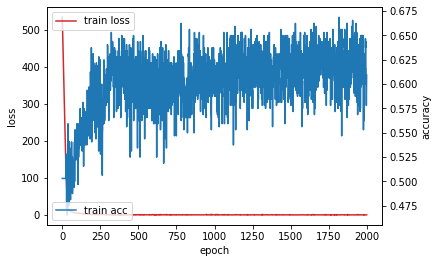

In [11]:
# 학습 과정 확인

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss', c = 'tab:red')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc', c = 'tab:blue')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [12]:
# 모델 저장
model.save("./MLmodels/ANN_model.h5")

## NN model 불러와서 진단

In [13]:
# 모델 불러오기
LoadedModel = keras.models.load_model("./MLmodels/ANN_model.h5")

In [14]:
Test_Data         = np.array(pd.read_csv('./K_FoldData/Test_Data'        , sep=",", header=None))
Test_Label_forANN = np.array(pd.read_csv('./K_FoldData/Test_Label_forANN', sep=",", header=None))

In [15]:
Loss, Accuracy = LoadedModel.evaluate(Test_Data, Test_Label_forANN, verbose=0)
print('[Performance of ANN model] \n')
print('Accuracy : {:.2f}%'.format(Accuracy*100))

[Performance of ANN model] 

Accuracy : 45.00%


In [16]:
# 예측값 확인
Predict_y = LoadedModel.predict(Test_Data)
pd.DataFrame(Predict_y)

,0,1
0,0.662727,3.372734e-01
1,0.286225,7.137746e-01
2,0.196183,8.038171e-01
3,0.036086,9.639140e-01
4,0.234349,7.656509e-01
5,0.004231,9.957689e-01
6,0.287005,7.129946e-01
7,0.314129,6.858706e-01
8,1.000000,2.623632e-11
9,0.242519,7.574806e-01
